Paste your OpenAI API key here:  ········


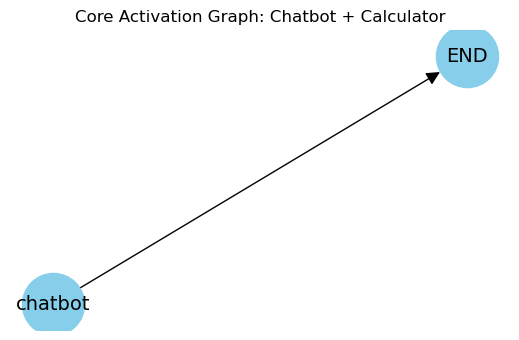

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [10]:
# --- Install dependencies (run once) ---
!pip install --quiet langchain langchain-core langchain-community langchain-openai openai langgraph networkx matplotlib

# --- Set OpenAI API Key securely ---
from getpass import getpass
import os
os.environ["OPENAI_API_KEY"] = getpass("Paste your OpenAI API key here: ")

# --- Imports ---
from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langgraph.graph import StateGraph, END
import networkx as nx
import matplotlib.pyplot as plt

# --- Calculator Tool (BODMAS support) ---
def calculator_tool(input: str) -> str:
    try:
        result = eval(input, {"__builtins__": {}})
        return str(result)
    except Exception as e:
        return f"Error: {e}"

calculator = Tool(
    name="Calculator",
    func=calculator_tool,
    description="Useful for answering math questions. Supports BODMAS."
)

# --- LLM Chatbot Node ---
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Define state structure explicitly
from typing import TypedDict

class ChatbotState(TypedDict):
    input: str
    output: str

def chatbot_node(state: ChatbotState) -> ChatbotState:
    user_input = state["input"]
    try:
        eval(user_input, {"__builtins__": {}})
        answer = calculator_tool(user_input)
        return {"output": f"The answer is: {answer}"}
    except:
        response = llm.invoke(user_input)
        return {"output": response.content}

# --- LangGraph Setup ---
graph = StateGraph(ChatbotState)
graph.add_node("chatbot", chatbot_node)
graph.set_entry_point("chatbot")
graph.add_edge("chatbot", END)

# --- Visualize the Graph ---
G = nx.DiGraph()
G.add_node("chatbot")
G.add_node("END")
G.add_edge("chatbot", "END")

pos = nx.spring_layout(G)
plt.figure(figsize=(5, 3))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=14, arrowsize=20)
plt.title("Core Activation Graph: Chatbot + Calculator")
plt.show()

# --- Example Usage ---
app = graph.compile()

# Correct invocation with explicit state structure
result1 = app.invoke({"input": "What is the capital of France?"})
print("Chatbot output:", result1["output"])

result2 = app.invoke({"input": "12 * (5 + 3) / 4"})
print("Calculator output:", result2["output"])
